In [1]:
import os, sys
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
#scipy.stats.pearsonr

In [2]:
#Bring in all data except PCs

dataFolder = "../data/"
#np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
    
soils = np.load(dataFolder+"Soils.npy")
#average across soil horizons
soils = pd.DataFrame(soils.mean(axis=1), columns=['awc', 'caco3', 'cec7', 'claytotal', 'dbovendry', 'ec', 
                                                  'gypsum', 'ksat', 'om', 'ph1to1h2o', 'sandtotal', 'silttotal','slope'])#.shape
#soils = soils.reshape(soils.shape[0], soils.shape[1] * soils.shape[2])
    
weather = np.load(dataFolder+"Weather_season_only.npy")
#weather = np.transpose(weather, (0, 2, 1))

phenotypes=pd.read_csv(dataFolder+"index_file.csv", index_col=0, low_memory=False)
rowIndexes=phenotypes.index.values
    #myyield = phenotypes["BU / ACRE"].values
    
    #for historical data we want to include 'Year', 'Latitude', 'Longitude', 'Altitude', 'Irrigated', 'Plant Density'
general = phenotypes[['Year', 'Latitude', 'Longitude', 'Altitude', 'Plant Density']]#.fillna(-1)
    #put together for output
    #ConsData = np.concatenate([soils, general], axis=1)
    
fertility = phenotypes[['% Clay', '% Sand', '% Silt', '%Ca Sat', '%H Sat','%K Sat', '%Mg Sat', '%Na Sat',
                            '1:1 S Salts mmho/cm', '1:1 Soil pH','Calcium ppm Ca', 'Magnesium ppm Mg',
                            'Mehlich P-III ppm P','Nitrate-N ppm N', 'Organic Matter LOI %', 'Potassium ppm K',
                            'Sodium ppm Na', 'Sulfate-S ppm S', 'WDRF Buffer pH', 'lbs N/A', 'Total K lbs/acre',
                            'Total N lbs/acre', 'Total P lbs/acre', 'Irrigation amount (inches)', 'Irrigated']]#.fillna(-1)

print(soils.shape, weather.shape, general.shape, fertility.shape)

(116991, 13) (116991, 8, 145) (116991, 5) (116991, 25)


In [3]:
#thought it might make more sense to drop duplicates before performing correlation but decided not to
def pearson_corr(x1,x2):
    #print(x1,x2)
    tmp = pd.DataFrame(x1,x2).reset_index().drop_duplicates()
    x1 = tmp.iloc[:,0]
    x2 = tmp.iloc[:,1]
    r = pearsonr(x1,x2)[0]
    return r

In [4]:
weath_avg = weather.mean(axis=2)
weath_avg = pd.DataFrame(weath_avg, columns= ["Day of year", "Day Length", "Maximum Temperature", "Minimum Temperature",
                                              "Precipitation", "Radiation","Vapor Pressure", "Cumulative thermal time"])

all_avg = pd.concat([general, soils, fertility, weath_avg], axis=1)
all_avg_corr = all_avg.corr()
#all_avg_corr = all_avg.corr(method=pearson_corr)

In [5]:
def create_heatmap(all_avg_corr, cent_zero):
    cols_sorted = all_avg_corr.mean().sort_values(ascending=False).index.to_list()
    corr = all_avg_corr.loc[cols_sorted][cols_sorted].copy()
    
    fig, ax = plt.subplots(figsize=(16,15))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        if cent_zero:
            ax = sns.heatmap(corr,mask=mask, square=True, center=0)
        else:
            ax = sns.heatmap(corr,mask=mask, square=True)

In [6]:
#create_heatmap(all_avg_corr, cent_zero=True)

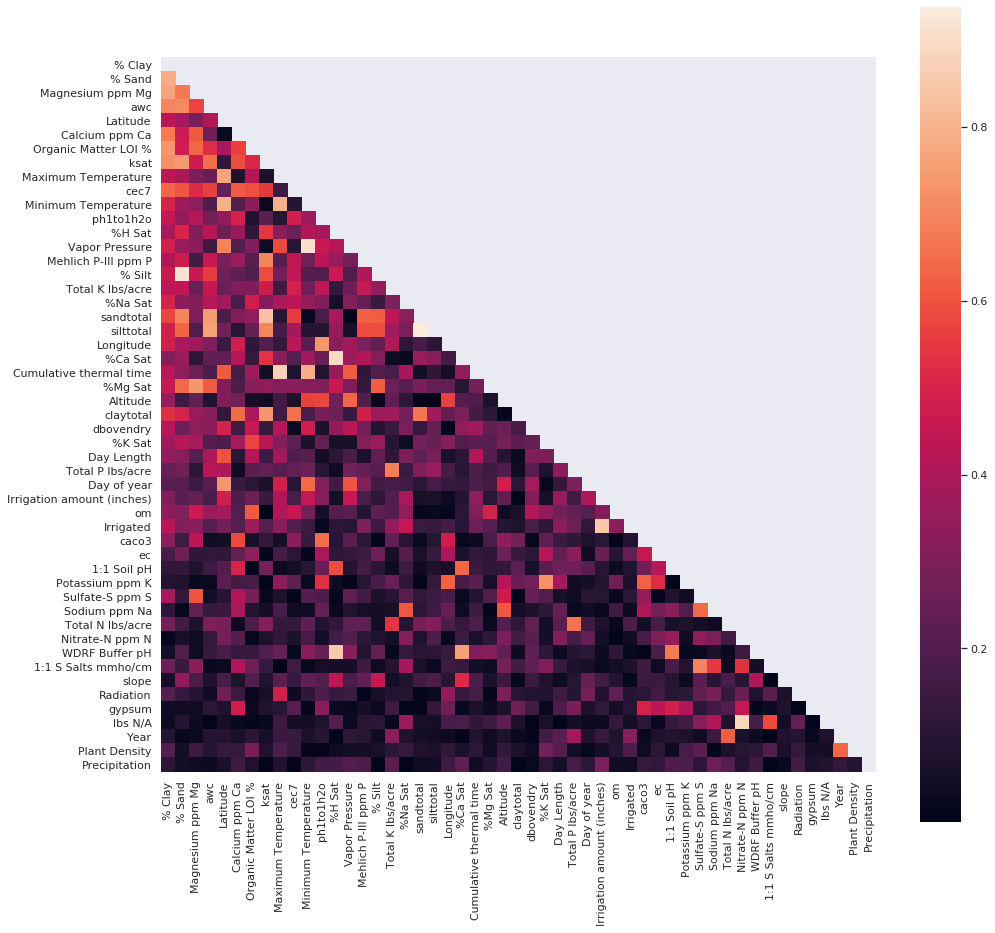

In [7]:
create_heatmap(all_avg_corr.abs(), cent_zero=False)

In [12]:
#create ordered list of correlations
def create_ordered_corr_list(all_avg_corr, cut_off = 0.5):
    corr_list = all_avg_corr.stack().reset_index()
    corr_list.columns = ["Feature1","Feature2","Correlation"]
    corr_list["Abs_corr"] = corr_list["Correlation"].abs()
    corr_list = corr_list[corr_list["Feature1"]!=corr_list["Feature2"]] #remove comparisons to self
    #remove duplicates
    corr_list = corr_list[corr_list.apply(lambda x: '-'.join(sorted([x['Feature1'],x['Feature2']])),axis=1).duplicated()]
    corr_list = corr_list.sort_values("Abs_corr", ascending=False).reset_index(drop=True)
    high_corrs = corr_list[corr_list["Abs_corr"]>=cut_off].copy()
    return corr_list, high_corrs

In [15]:
corr_list, high_corrs = create_ordered_corr_list(all_avg_corr, cut_off = 0.5)
corr_list.to_csv("../data/Results/Feature_correlations_all.csv")

In [26]:
#create correlations for just G2F data
g2f_avg = all_avg.loc[phenotypes[phenotypes["G2F"]].index.to_list()].copy()
g2f_avg_corr = g2f_avg.corr()

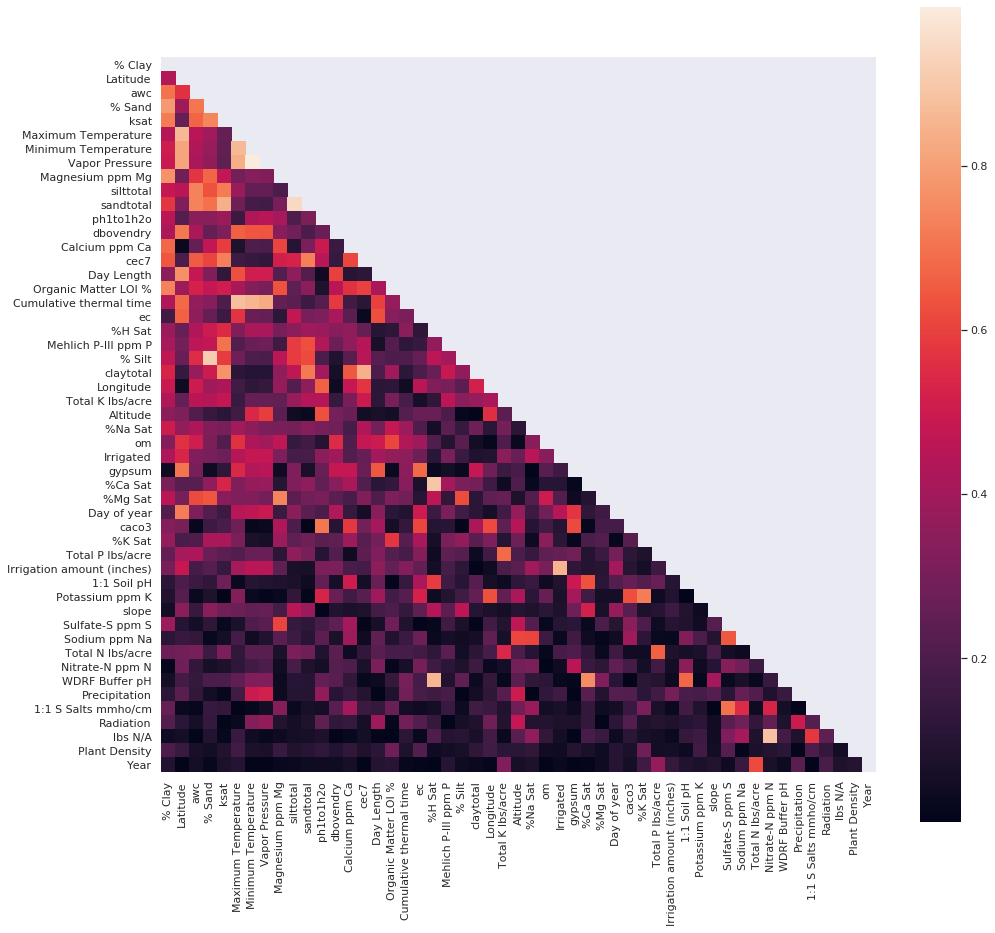

In [27]:
create_heatmap(g2f_avg_corr.abs(), cent_zero=False)

In [28]:
corr_list, high_corrs = create_ordered_corr_list(g2f_avg_corr, cut_off = 0.5)
corr_list.to_csv("../data/Results/Feature_correlations_G2F.csv")
high_corrs

Feature1             Feature2  Correlation  Abs_corr
0          Vapor Pressure  Minimum Temperature     0.993972  0.993972
1               silttotal            sandtotal    -0.946026  0.946026
2                  % Silt               % Sand    -0.914616  0.914616
3                  %H Sat              %Ca Sat    -0.895934  0.895934
4                 lbs N/A      Nitrate-N ppm N     0.887530  0.887530
..                    ...                  ...          ...       ...
127                    om                  awc     0.508968  0.508968
128  Organic Matter LOI %                 ksat    -0.508278  0.508278
129        Vapor Pressure           Day Length    -0.506129  0.506129
130   Minimum Temperature               % Clay    -0.502797  0.502797
131        Calcium ppm Ca          1:1 Soil pH     0.501404  0.501404

[132 rows x 4 columns]

In [21]:
soils_simple = pd.read_csv("../data/Soil_data/G2F_all_soils_no_impute.csv", index_col=0)
soils_simple.drop(columns=["horizons"]).corr()

awc     caco3      cec7  claytotal  dbovendry        ec  \
awc        1.000000 -0.034102  0.603621   0.282420  -0.448821 -0.316539   
caco3     -0.034102  1.000000  0.310759   0.401072   0.249067  0.608290   
cec7       0.603621  0.310759  1.000000   0.797872  -0.057533 -0.013528   
claytotal  0.282420  0.401072  0.797872   1.000000   0.191714  0.168333   
dbovendry -0.448821  0.249067 -0.057533   0.191714   1.000000  0.343744   
ec        -0.316539  0.608290 -0.013528   0.168333   0.343744  1.000000   
gypsum    -0.196310  0.550553  0.308167   0.444996   0.394407  0.559377   
ksat      -0.627667 -0.163340 -0.699468  -0.747873   0.211190  0.170439   
om         0.530079 -0.200181  0.460313  -0.017167  -0.577430 -0.347495   
ph1to1h2o  0.357299  0.653313  0.464915   0.317700  -0.175902  0.297667   
sandtotal -0.719673 -0.030577 -0.731604  -0.687618   0.179750  0.292272   
silttotal  0.753093 -0.163108  0.514857   0.376523  -0.329435 -0.459856   
slope      0.132204 -0.168795  0.066267   0.093803  -0.122302 -0.234813   

             gypsum      ksat        om  ph1to1h2o  sandtotal  silttotal  \
awc       -0.196310 -0.627667  0.530079   0.357299  -0.719673   0.753093   
caco3      0.550553 -0.163340 -0.200181   0.653313  -0.030577  -0.163108   
cec7       0.308167 -0.699468  0.460313   0.464915  -0.731604   0.514857   
claytotal  0.444996 -0.747873 -0.017167   0.317700  -0.687618   0.376523   
dbovendry  0.394407  0.211190 -0.577430  -0.175902   0.179750  -0.329435   
ec         0.559377  0.170439 -0.347495   0.297667   0.292272  -0.459856   
gypsum     1.000000 -0.137584 -0.168546   0.220359   0.006468  -0.237866   
ksat      -0.137584  1.000000 -0.186358  -0.355294   0.840125  -0.693851   
om        -0.168546 -0.186358  1.000000   0.113480  -0.180567   0.197963   
ph1to1h2o  0.220359 -0.355294  0.113480   1.000000  -0.347773   0.278997   
sandtotal  0.006468  0.840125 -0.180567  -0.347773   1.000000  -0.927968   
silttotal -0.237866 -0.693851  0.197963   0.278997  -0.927968   1.000000   
slope     -0.220035 -0.283456 -0.100672   0.039318  -0.351765   0.403475   

              slope  
awc        0.132204  
caco3     -0.168795  
cec7       0.066267  
claytotal  0.093803  
dbovendry -0.122302  
ec        -0.234813  
gypsum    -0.220035  
ksat      -0.283456  
om        -0.100672  
ph1to1h2o  0.039318  
sandtotal -0.351765  
silttotal  0.403475  
slope      1.000000

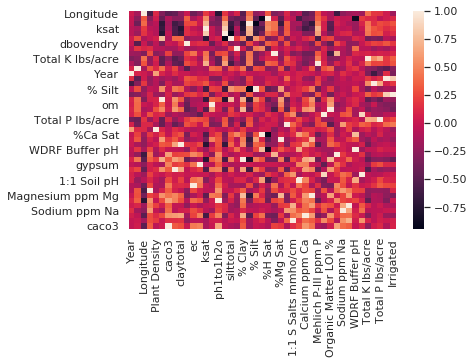

In [50]:
ax = sns.heatmap(all_but_weath_corr.loc[cols_sorted])

In [8]:
soils_simple.drop(columns=["horizons"]).corr()

awc     caco3      cec7  claytotal  dbovendry        ec  \
awc        1.000000 -0.034102  0.603621   0.282420  -0.448821 -0.316539   
caco3     -0.034102  1.000000  0.310759   0.401072   0.249067  0.608290   
cec7       0.603621  0.310759  1.000000   0.797872  -0.057533 -0.013528   
claytotal  0.282420  0.401072  0.797872   1.000000   0.191714  0.168333   
dbovendry -0.448821  0.249067 -0.057533   0.191714   1.000000  0.343744   
ec        -0.316539  0.608290 -0.013528   0.168333   0.343744  1.000000   
gypsum    -0.196310  0.550553  0.308167   0.444996   0.394407  0.559377   
ksat      -0.627667 -0.163340 -0.699468  -0.747873   0.211190  0.170439   
om         0.530079 -0.200181  0.460313  -0.017167  -0.577430 -0.347495   
ph1to1h2o  0.357299  0.653313  0.464915   0.317700  -0.175902  0.297667   
sandtotal -0.719673 -0.030577 -0.731604  -0.687618   0.179750  0.292272   
silttotal  0.753093 -0.163108  0.514857   0.376523  -0.329435 -0.459856   
slope      0.132204 -0.168795  0.066267   0.093803  -0.122302 -0.234813   

             gypsum      ksat        om  ph1to1h2o  sandtotal  silttotal  \
awc       -0.196310 -0.627667  0.530079   0.357299  -0.719673   0.753093   
caco3      0.550553 -0.163340 -0.200181   0.653313  -0.030577  -0.163108   
cec7       0.308167 -0.699468  0.460313   0.464915  -0.731604   0.514857   
claytotal  0.444996 -0.747873 -0.017167   0.317700  -0.687618   0.376523   
dbovendry  0.394407  0.211190 -0.577430  -0.175902   0.179750  -0.329435   
ec         0.559377  0.170439 -0.347495   0.297667   0.292272  -0.459856   
gypsum     1.000000 -0.137584 -0.168546   0.220359   0.006468  -0.237866   
ksat      -0.137584  1.000000 -0.186358  -0.355294   0.840125  -0.693851   
om        -0.168546 -0.186358  1.000000   0.113480  -0.180567   0.197963   
ph1to1h2o  0.220359 -0.355294  0.113480   1.000000  -0.347773   0.278997   
sandtotal  0.006468  0.840125 -0.180567  -0.347773   1.000000  -0.927968   
silttotal -0.237866 -0.693851  0.197963   0.278997  -0.927968   1.000000   
slope     -0.220035 -0.283456 -0.100672   0.039318  -0.351765   0.403475   

              slope  
awc        0.132204  
caco3     -0.168795  
cec7       0.066267  
claytotal  0.093803  
dbovendry -0.122302  
ec        -0.234813  
gypsum    -0.220035  
ksat      -0.283456  
om        -0.100672  
ph1to1h2o  0.039318  
sandtotal -0.351765  
silttotal  0.403475  
slope      1.000000

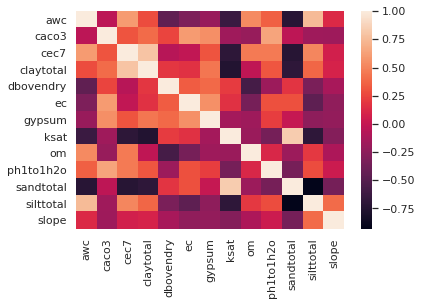

In [191]:
ax = sns.heatmap(soils.drop(columns=["horizons"]).corr())#, annot=True)

In [55]:
weath = pd.read_csv("../data/Weather_data/G2F_all_met_data_365.csv", index_col=0)
weath["ID_Year"]=weath["ID"]

In [56]:
weath = weath[weath["year"].isin([2014,2015,2016,2017])]
weath = weath[weath["ID_Year"].str.split("@", expand=True)[1].astype(int) == weath["year"]].reset_index(drop=True)
#weath

In [137]:
weath["mean"] = weath[[str(x) for x in range(1,366)]].mean(axis=1)
tmp = weath[["ID_Year","level_1","mean"]].copy()
#tmp.index = tmp["level_1"]
#tmp = tmp.reset_index(drop=True)
#tmp.index = pd.MultiIndex.from_arrays([tmp.index.tolist(),tmp["level_1"].tolist()])

tmp = tmp.pivot(index="ID_Year", columns="level_1", values="mean")

In [138]:
tmp.corr()

level_1      dayL      maxt      mint    precip      radn        vp
level_1                                                            
dayL     1.000000  0.545070  0.522344 -0.326689  0.381053  0.522812
maxt     0.545070  1.000000  0.954894 -0.522995  0.686996  0.927149
mint     0.522344  0.954894  1.000000 -0.461619  0.495944  0.987150
precip  -0.326689 -0.522995 -0.461619  1.000000 -0.165179 -0.392410
radn     0.381053  0.686996  0.495944 -0.165179  1.000000  0.470920
vp       0.522812  0.927149  0.987150 -0.392410  0.470920  1.000000

In [183]:
start = 1
end = 365
corr_by_day = []
avg_corr = []
skipped = []
for day in [str(x) for x in range(start,end+1)]:
    corr_tbl = weath[["ID_Year", "level_1", day]].pivot(index="ID_Year", columns="level_1", values=day).corr().copy()
    corr_by_day.append(corr_tbl)
    #print(day)
    if len(corr_tbl.dropna()) != 6:
        skipped.append(day)
        continue
    if day == str(start):
        avg_corr = corr_tbl
    else:
        avg_corr = (avg_corr + corr_tbl)
print(skipped)
avg_corr = avg_corr / (end+1-start-len(skipped))

['81', '263', '264']


In [187]:
avg_corr

level_1      dayL      maxt      mint    precip      radn        vp
level_1                                                            
dayL     1.000000  0.021337 -0.032512 -0.069693  0.235449 -0.029664
maxt     0.021337  1.000000  0.817988 -0.190206  0.293735  0.755279
mint    -0.032512  0.817988  1.000000 -0.057402 -0.161787  0.953918
precip  -0.069693 -0.190206 -0.057402  1.000000 -0.357396 -0.024596
radn     0.235449  0.293735 -0.161787 -0.357396  1.000000 -0.171383
vp      -0.029664  0.755279  0.953918 -0.024596 -0.171383  1.000000

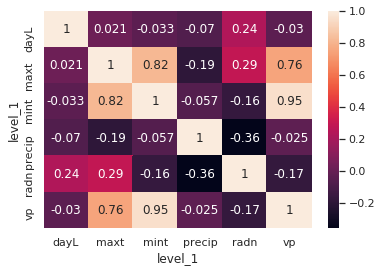

In [189]:
ax = sns.heatmap(avg_corr, annot=True)

In [ ]:
#June 1 = 152
#Oct 1 = 274